## Imports

In [1]:
import itertools
import numpy as np
import jax
import jax.numpy as jnp
import h5py
import natsort
import torch
from jax.tree_util import tree_map
from torch.utils import data
from functools import partial
from torch.utils.data import Dataset, TensorDataset, DataLoader
from scipy.ndimage import geometric_transform
from scipy.ndimage import gaussian_filter
import tensorflow as tf

2024-02-07 20:24:30.042309: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Example - training an unconditional diffusion model

### Dataset

First we need a dataset containing samples whose distribution is to be modeled by the diffusion model. This is application dependent so below we use a pair of dummy train and evaluation dataloaders, which should be replaced with realistic ones for your specific use case.

Our code setup accepts any Python Iterable objects to be used as dataloaders. The expectation is that they should continuously yield a dictionary with a field named `x` whose corresponding value is a numpy array with shape `(batch, *spatial_dims, channels)`.

In [2]:
# Parameters for the computational task.

L = 4 # number of levels (even number)
s = 5 # leaf size
r = 3 # rank

# Discretization of Omega (n_eta * n_eta).
neta = (2**L)*s

# Number of sources/detectors (n_sc).
# Discretization of the domain of alpha in polar coordinates (n_theta * n_rho).
# For simplicity, these values are set equal (n_sc = n_theta = n_rho), facilitating computation.
nx = (2**L)*s

# Standard deviation for the Gaussian blur.
blur_sigma = 0.5

# Batch size.
BATCH_SIZE = 16

# Number of training datapoints.
NTRAIN = 20000

# Number of testing datapoints.
NTEST = 512

In [3]:
#name = 'Data/traindata_smooth_sigma_0.04'
name = 'Data/traindata_shepp_logan'

# Loading and preprocessing perturbation data (eta)
with h5py.File(f'{name}/eta.h5', 'r') as f:
    # Read eta data, apply Gaussian blur, and reshape
    eta_re = f[list(f.keys())[0]][:NTRAIN, :].reshape(-1, neta, neta)
    blur_fn = lambda x: gaussian_filter(x, sigma=blur_sigma)
    eta_re = np.stack([blur_fn(eta_re[i, :, :]) for i in range(NTRAIN)]).astype('float32')

# Loading and preprocessing scatter data (Lambda)
with h5py.File(f'{name}/scatter.h5', 'r') as f:
    keys = natsort.natsorted(f.keys())

    # Process real part of scatter data
    tmp1 = f[keys[3]][:NTRAIN, :].reshape((-1, nx, nx))
    tmp2 = f[keys[4]][:NTRAIN, :].reshape((-1, nx, nx))
    tmp3 = f[keys[5]][:NTRAIN, :].reshape((-1, nx, nx))
    scatter_re = np.stack((tmp1, tmp2, tmp3), axis=-1)

    # Process imaginary part of scatter data
    tmp1 = f[keys[0]][:NTRAIN, :].reshape((-1, nx, nx))
    tmp2 = f[keys[1]][:NTRAIN, :].reshape((-1, nx, nx))
    tmp3 = f[keys[2]][:NTRAIN, :].reshape((-1, nx, nx))
    scatter_im = np.stack((tmp1, tmp2, tmp3), axis=-1)

    # Combine real and imaginary parts
    scatter = np.stack((scatter_re, scatter_im), axis=1).astype('float32')

# Clean up temporary variables to free memory
del scatter_re, scatter_im, tmp1, tmp2, tmp3

In [4]:
scatter = np.swapaxes(np.swapaxes(np.swapaxes(scatter,1,2),2,3),3,4)
scatter = np.reshape(scatter,(NTRAIN,80,80,6))
eta_re = np.array([eta_re])
eta_re = np.swapaxes(np.swapaxes(np.swapaxes(eta_re,0,1),1,2),2,3)

In [5]:
scatter_eta_re = np.concatenate((scatter,eta_re),axis=-1)

In [6]:
scatter_eta_re_norm = (scatter_eta_re- np.mean(scatter_eta_re,axis=0))/(np.std(scatter_eta_re,axis=0)+ 1e-4)

In [7]:
scatter_eta_re_norm.shape

(20000, 80, 80, 7)

In [8]:
eta_re_norm = (eta_re- np.mean(eta_re,axis=0))/(np.std(eta_re,axis=0)+ 1e-4)

In [9]:
eta_re_norm.shape

(20000, 80, 80, 1)

In [10]:
# To avoid tf to use GPU memory
tf.config.set_visible_devices([], device_type='GPU')

batch_size = 16
dict_data = {"x": eta_re_norm}
dataset = tf.data.Dataset.from_tensor_slices(dict_data)
dataset = dataset.repeat()
dataset = dataset.batch(batch_size)
dataset = dataset.prefetch(tf.data.AUTOTUNE)
dataset = eval_dataloader = dataset.as_numpy_iterator()

2024-02-07 20:26:07.602408: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [11]:
data_std = np.std(eta_re_norm)

In [12]:
print(data_std)

0.7853226


### Architecture

Next let's define the U-Net backbone. The "Preconditioning" is merely to ensure that the inputs and outputs of the network are roughly standardized (for more details, see Appendix B.6. in [this paper](https://arxiv.org/abs/2206.00364)).

In [13]:
import functools

from clu import metric_writers
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import optax
import orbax.checkpoint as ocp

from swirl_dynamics import templates
from swirl_dynamics.lib import diffusion as dfn_lib
from swirl_dynamics.lib import solvers as solver_lib
from swirl_dynamics.projects import probabilistic_diffusion as dfn

In [14]:
denoiser_model = dfn_lib.PreconditionedDenoiser(
    out_channels=1,
    num_channels=(64, 128, 256),
    downsample_ratio=(2, 2, 2),
    num_blocks=4,
    noise_embed_dim=128,
    padding="SAME",
    use_attention=True,
    use_position_encoding=True,
    num_heads=8,
    sigma_data=data_std,
)

### Training

For diffusion model training, the above-defined U-Net backbone serves as a denoiser, which takes as input a batch of (isotropic Gaussian noise) corrupted samples and outputs its best guess for what the uncorrupted image would be.

Besides the backbone architecture, we also need to specify how to sample the noise levels (i.e. standard deviations) used to corrupt the samples and the weighting for each noise level in the loss function (for other options and configurations, see [`swirl_dynamics.lib.diffusion.diffusion`](https://github.com/google-research/swirl-dynamics/blob/main/swirl_dynamics/lib/diffusion/diffusion.py)):

In [15]:
diffusion_scheme = dfn_lib.Diffusion.create_variance_exploding(
    sigma=dfn_lib.tangent_noise_schedule(),
    data_std=data_std,
)

model = dfn.DenoisingModel(
    # `input_shape` must agree with the expected sample shape (without the batch
    # dimension), which in this case is simply the dimensions of a single MNIST
    # sample.
    input_shape=(80, 80, 1),
    denoiser=denoiser_model,
    noise_sampling=dfn_lib.log_uniform_sampling(
        diffusion_scheme, clip_min=1e-4, uniform_grid=True,
    ),
    noise_weighting=dfn_lib.edm_weighting(data_std=data_std),
)

We are now ready to define the learning parameters.

In [21]:
# !rm -R -f $workdir  # optional: clear the working directory

In [18]:
num_train_steps = 100000  #@param
workdir = "/tmp/diffusion_demo_eta_2"  #@param
initial_lr = 0.0  #@param
peak_lr = 1e-4  #@param
warmup_steps = 1000  #@param
end_lr = 1e-6  #@param
ema_decay = 0.999  #@param
ckpt_interval = 1000  #@param
max_ckpt_to_keep = 5  #@param
#train_batch_size = 32  #@param
#eval_batch_size = 32  #@param

To start training, we first need to initialize the trainer.

In [19]:
# NOTE: use `trainers.DistributedDenoisingTrainer` for multi-device
# training with data parallelism.
trainer = dfn.DenoisingTrainer(
    model=model,
    rng=jax.random.PRNGKey(888),
    optimizer=optax.adam(
        learning_rate=optax.warmup_cosine_decay_schedule(
            init_value=initial_lr,
            peak_value=peak_lr,
            warmup_steps=warmup_steps,
            decay_steps=num_train_steps,
            end_value=end_lr,
        ),
    ),
    # We keep track of an exponential moving average of the model parameters
    # over training steps. This alleviates the "color-shift" problems known to
    # exist in the diffusion models.
    ema_decay=ema_decay,
)

Now we are ready to kick start training. A couple of "callbacks" are passed to assist with monitoring and checkpointing.

The first step will be a little slow as Jax needs to JIT compile the step function (the same goes for the first step where evaluation is performed). Fortunately, steps after that should continue much faster.

In [20]:
templates.run_train(
    train_dataloader=dataset,
    trainer=trainer,
    workdir=workdir,
    total_train_steps=num_train_steps,
    metric_writer=metric_writers.create_default_writer(
        workdir, asynchronous=False
    ),
    metric_aggregation_steps=100,
    eval_dataloader=eval_dataloader,
    eval_every_steps = 1000,
    num_batches_per_eval = 2,
    callbacks=(
        # This callback displays the training progress in a tqdm bar
        templates.TqdmProgressBar(
            total_train_steps=num_train_steps,
            train_monitors=("train_loss",),
        ),
        # This callback saves model checkpoint periodically
        templates.TrainStateCheckpoint(
            base_dir=workdir,
            options=ocp.CheckpointManagerOptions(
                save_interval_steps=ckpt_interval, max_to_keep=max_ckpt_to_keep
            ),
        ),
    ),
)

  0%|          | 0/100000 [00:00<?, ?step/s]

2024-02-07 20:28:35.786542: W external/tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 16.27GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-02-07 20:28:35.786608: W external/tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 16.27GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-02-07 20:28:35.804735: W external/tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 16.27GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-02-07 20:28:35.804786: W external/tsl/tsl/framework/bfc_allocator.cc:296] All

### Inference

#### trainers generation

The trained denoiser may be used to generate trainers samples.

First, let's try to restore the model from checkpoint.

In [21]:
# Restore train state from checkpoint. By default, the move recently saved
# checkpoint is restored. Alternatively, one can directly use
# `trainer.train_state` if continuing from the training section above.
trained_state = dfn.DenoisingModelTrainState.restore_from_orbax_ckpt(
    f"{workdir}/checkpoints", step=None
)
# Construct the inference function
denoise_fn = dfn.DenoisingTrainer.inference_fn_from_state_dict(
    trained_state, use_ema=True, denoiser=denoiser_model
)

Diffusion samples are generated by plugging the trained denoising function in a stochastic differential equation (parametrized by the diffusion scheme) and solving it backwards in time.

In [22]:
sampler = dfn_lib.SdeSampler(
    input_shape=(80, 80, 1),
    integrator=solver_lib.EulerMaruyama(),
    tspan=dfn_lib.edm_noise_decay(
        diffusion_scheme, rho=7, num_steps=256, end_sigma=1e-3,
    ),
    scheme=diffusion_scheme,
    denoise_fn=denoise_fn,
    guidance_transforms=(),
    apply_denoise_at_end=True,
    return_full_paths=False,  # Set to `True` if the full sampling paths are needed
)

In [23]:
# Optional: JIT compile the generate function so that it runs faster if
# repeatedly called.
generate = jax.jit(sampler.generate, static_argnames=('num_samples',))

In [24]:
samples = generate(
    rng=jax.random.PRNGKey(8888), num_samples=4
)

In the output, `samples` is the generated samples and `aux` is the auxiliary output from the generation process. It contains the full trajectory of the SDE, which may be probed to better understand the generation behaviors.

In [25]:
print(samples.shape)

(4, 80, 80, 1)


In [26]:
samples_denorm = np.zeros((4, 80, 80, 1))
for i in range(4):
    samples_denorm[i,:,:,:] = samples[i,:,:,:]*(np.std(eta_re,axis=0)+ 1e-4) + np.mean(eta_re,axis=0)

Visualize the generated samples

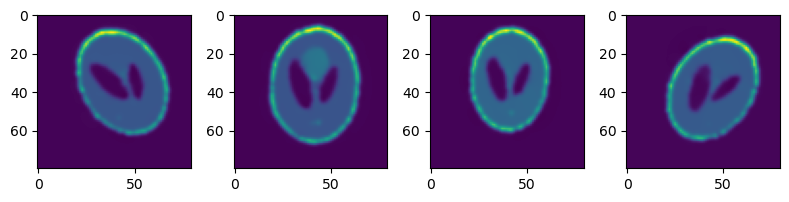

In [27]:
# Plot generated samples
#vmin, vmax = -3, 3

# Plot generated samples
fig, ax = plt.subplots(1, 4, figsize=(8, 2))
for i in range(4):
    im = ax[i].imshow(samples_denorm[i, :, :, 0])#, vmin=vmin, vmax=vmax)

plt.tight_layout()
plt.show()

#### A-posteriori guided generation

We may post-process a trained denoising function to perform "guided" generation. Below we provide an example for a super-resolution task: generating high-resolution images given a low-resolution one.

To achieve this, we provide the low-resolution image as the guide input and post-process the denoiser to favor generating samples which, when downsampled, give values close to these guide input.

In [53]:
guidance_fn = dfn_lib.InfillFromSlices(
    # This specifies location of the guide input using python slices.
    # Here it implies that the guide input corresponds the 7x7 patch in the
    # center of the image.
    slices=(slice(None), slice(40, 47), slice(40, 47)),

    # This is a parameter that controls how "hard" the denoiser pushes for
    # the conditioning to be satisfied. It is a tradeoff between strictness of
    # constraint satisfication and diversity in the generated samples.
    guide_strength=0.1,
)

In [54]:
guided_sampler = dfn_lib.SdeSampler(
    input_shape=(80, 80, 1),
    integrator=solver_lib.EulerMaruyama(),
    tspan=dfn_lib.edm_noise_decay(
        diffusion_scheme, rho=7, num_steps=256, end_sigma=1e-3,
    ),
    scheme=diffusion_scheme,
    denoise_fn=denoise_fn,
    guidance_transforms=(guidance_fn,),
    apply_denoise_at_end=True,
    return_full_paths=False,
)

guided_generate = jax.jit(guided_sampler.generate, static_argnames=('num_samples',))

In [55]:
test_ds = dataset
test_example = next(iter(test_ds))["x"]
example_guidance_inputs = {'observed_slices': test_example[:, 40:47, 40:47]}

In [56]:
guided_samples = guided_generate(
    rng=jax.random.PRNGKey(66),
    num_samples=16,
    # Note that the shape of the guidance input must be compatible with
    # `sample[guidance_fn.slices]`
    guidance_inputs=example_guidance_inputs,
)

In [57]:
guided_samples_denorm = np.zeros((16, 80, 80, 1))
for i in range(16):
    guided_samples_denorm[i,:,:,:] = guided_samples[i,:,:,:]*(np.std(eta_re,axis=0)+ 1e-4) + np.mean(eta_re,axis=0)

Visualize guided samples

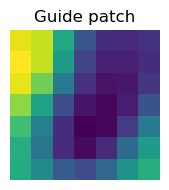

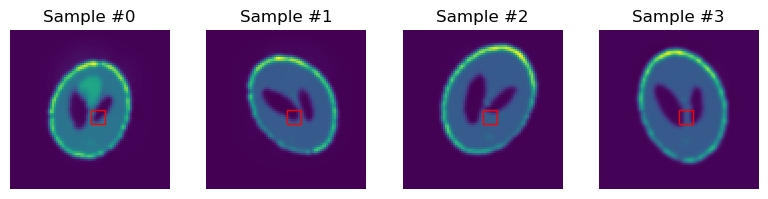

In [58]:
# Plot guide patch.
#vmin, vmax = -3, 3
fig, ax = plt.subplots(1, 1, figsize=(2, 2))
im = ax.imshow(test_example[0, 40:47, 40:47, 0])#, vmin=vmin, vmax=vmax)
ax.axis("off")
ax.set_title("Guide patch")
plt.tight_layout()
plt.show()

# Plot generated samples.
fig, ax = plt.subplots(1, 4, figsize=(8, 2))
for i in range(4):
    im = ax[i].imshow(guided_samples_denorm[i, :, :, 0])#, vmin=vmin, vmax=vmax)
    # Mark out the patch where guidance is enabled.
    square = patches.Rectangle(
        xy=(40, 40), width=7, height=7, fill=False, edgecolor='red'
    )
    ax[i].add_patch(square)
    ax[i].axis("off")
    ax[i].set_title(f"Sample #{i}")

plt.tight_layout()
plt.show()